In [ ]:
%load_ext autoreload
%load_ext line_profiler
%load_ext snakeviz
%autoreload 2
%matplotlib notebook

from seqdata.core import *
from seqdata.model import *
from seqdata.learner import *
from seqdata.prodiag import *
from fastai2.basics import *
from fastai2.callback.schedule import *
from fastai2.callback.rnn import *

## Input Only

In [ ]:
f_paths = '/mnt/Data/Systemidentification/EEG/Medium/'
hdf_files = L([f for f in get_hdf_files(f_paths) if 'Person2' in str(f)])

seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u'],TensorSequencesInput),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput)),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=1000,stp_sz=1000,clm='u')]),
                 splitter=FuncSplitter(lambda o: 'Realization7' in str(o['path']) ))

db = seq.databunch(hdf_files,shufflish=True,bs=64)

<IPython.core.display.Javascript object>


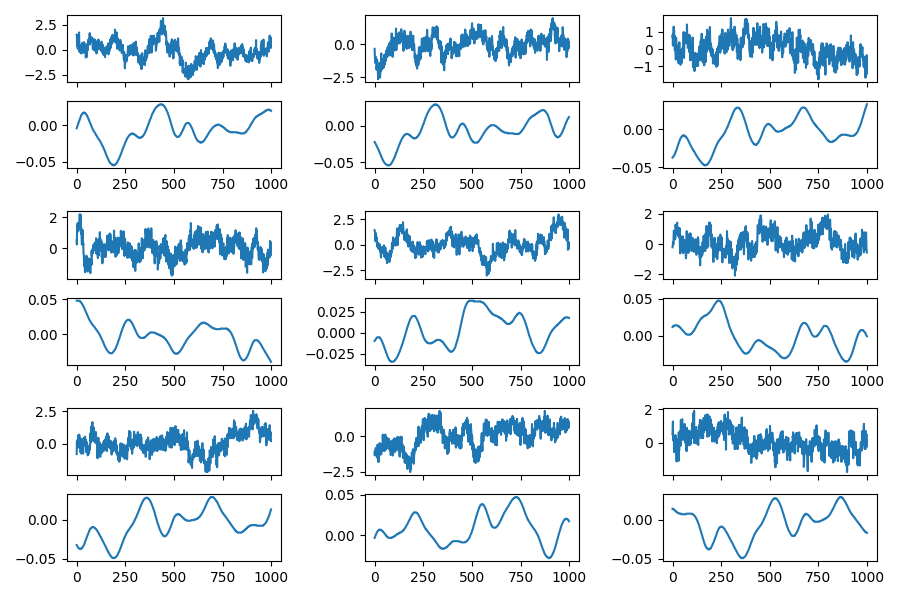

In [ ]:
db.show_batch()

In [ ]:
lrn= GRULearner(db,num_layers=3,hidden_size=100,n_skip=300,alpha=1,beta=1)
# lrn= TCNLearner(db,hl_depth=9,hl_width=100,early_stop=0,alpha=1,beta=1)
# lrn= QRNNLearner(db,n_layers=4,hidden_size=100,n_skip=50,alpha=1,beta=1,window=2)

<IPython.core.display.Javascript object>


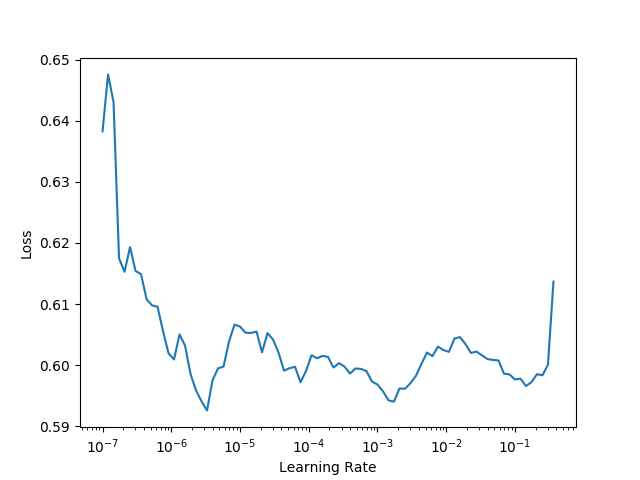

In [ ]:
lrn.lr_find()

In [ ]:
lrn.fit_one_cycle(20,lr_max=3e-3,pct_start=0.05)

epoch,train_loss,valid_loss,fun_rmse,time
0,0.595286,0.603251,0.776592,00:08
1,0.595188,0.605089,0.777773,00:08
2,0.593431,0.603242,0.776586,00:08
3,0.591981,0.603871,0.776992,00:08
4,0.591648,0.603343,0.776652,00:08
5,0.591847,0.603260,0.776598,00:08
6,0.592428,0.603192,0.776554,00:08
7,0.592181,0.603982,0.777063,00:08
8,0.593032,0.603155,0.776530,00:08
9,0.593226,0.602961,0.776405,00:08


<IPython.core.display.Javascript object>


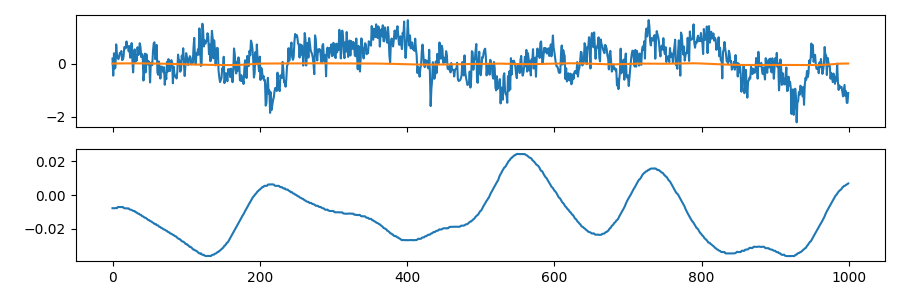

<IPython.core.display.Javascript object>


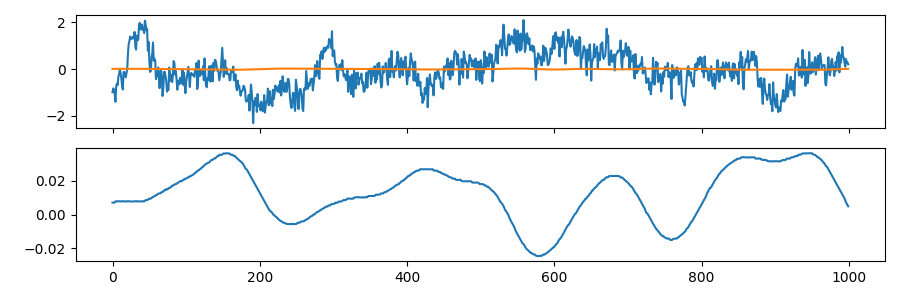

In [ ]:
lrn.show_results(ds_idx=1,max_n=2)

## ProDiag

In [ ]:
seq = DataBlock(blocks=(SequenceBlock.from_hdf(['u','y'],TensorSequencesInput),
                        SequenceBlock.from_hdf(['y'],TensorSequencesOutput)),
                 get_items=CreateDict([DfHDFCreateWindows(win_sz=200,stp_sz=200,clm='u')]),
                 splitter=FuncSplitter(lambda o: 'Realization7' in str(o['path']) ))

db = seq.databunch(hdf_files,shufflish=True,bs=64)

<IPython.core.display.Javascript object>


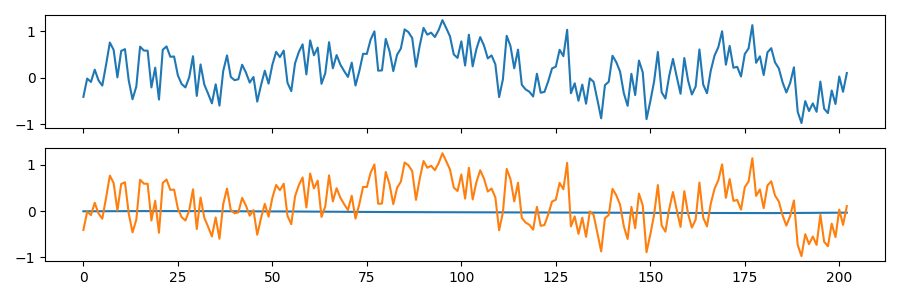

In [ ]:
db.show_batch(max_n=1)

In [ ]:
init = 200-10
model = ProgDiag_GRU(2,1,init)
lrn = Learner(db,model,loss_func=nn.MSELoss(),cbs=ProDiagTrainer(init),opt_func=ranger)

<IPython.core.display.Javascript object>


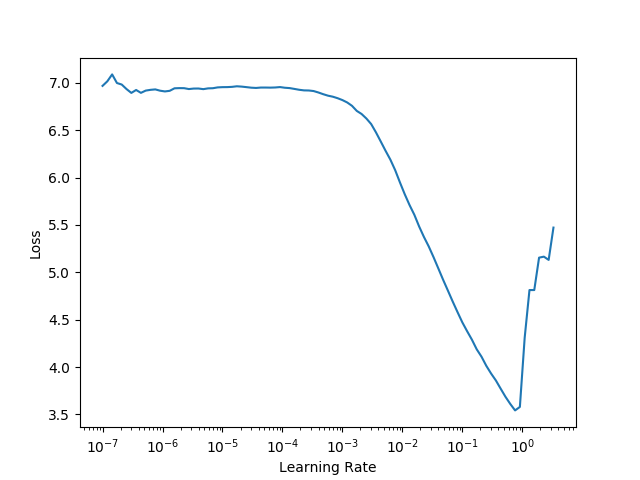

In [ ]:
lrn.lr_find()

In [ ]:
lrn.fit_one_cycle(30,lr_max=3e-3)

epoch,train_loss,valid_loss,time
0,4.278663,0.569052,00:11
1,0.676125,0.470630,00:10
2,0.177653,0.138929,00:10
3,0.141245,0.130259,00:11
4,0.134324,0.126800,00:10
5,0.127399,0.120792,00:10
6,0.125639,0.124116,00:10
7,0.121645,0.120139,00:10
8,0.120747,0.119927,00:10
9,0.122474,0.119350,00:10


<IPython.core.display.Javascript object>


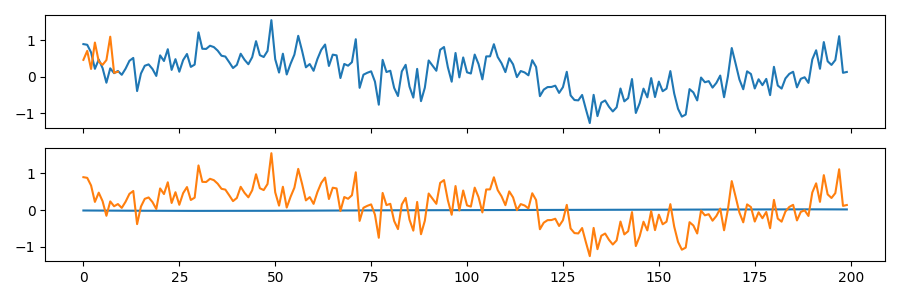

<IPython.core.display.Javascript object>


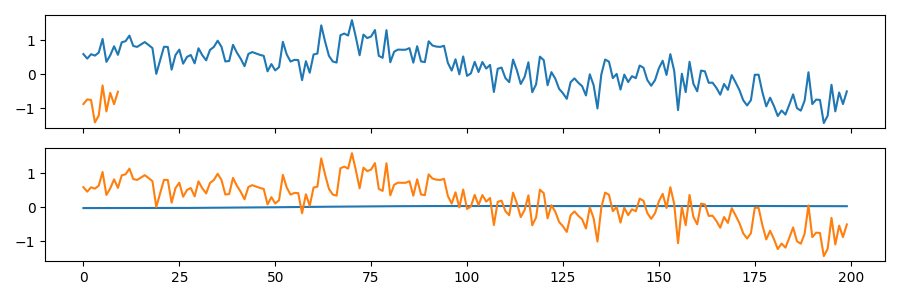

In [ ]:
lrn.show_results(max_n=2)

In [ ]:
lrn.pred.shape

torch.Size([64, 10, 2])

In [ ]:
lrn.y.shape

torch.Size([64, 10, 2])

<IPython.core.display.Javascript object>


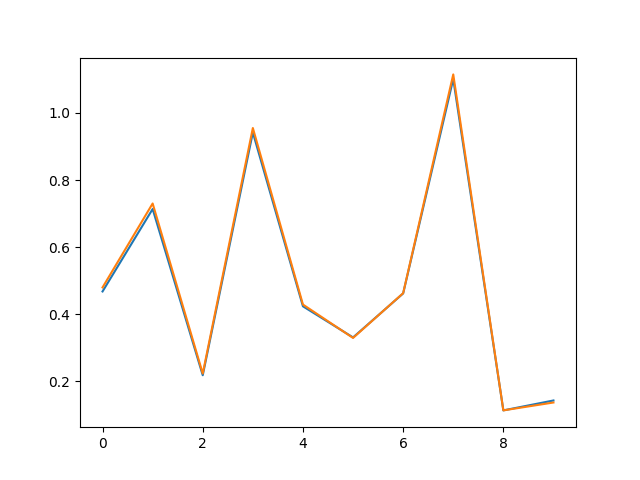

<IPython.core.display.Javascript object>


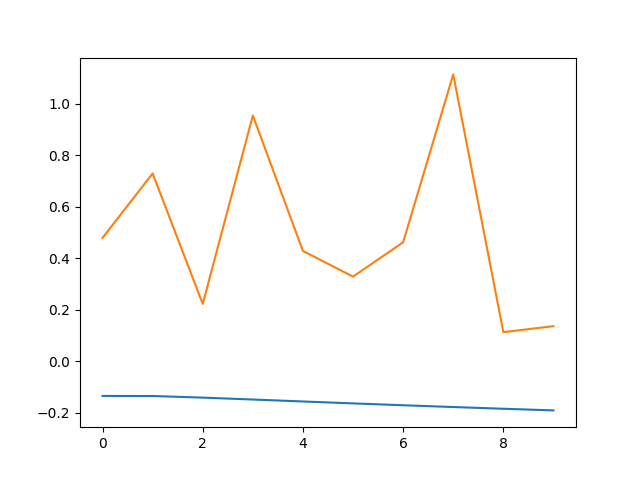

In [ ]:
btch = 0
plt.figure()
plt.plot(lrn.pred.cpu()[btch,:,0])
plt.plot(lrn.y.cpu()[btch,:,0])
plt.figure()
plt.plot(lrn.pred.cpu()[btch,:,1])
plt.plot(lrn.y.cpu()[btch,:,1])

<IPython.core.display.Javascript object>


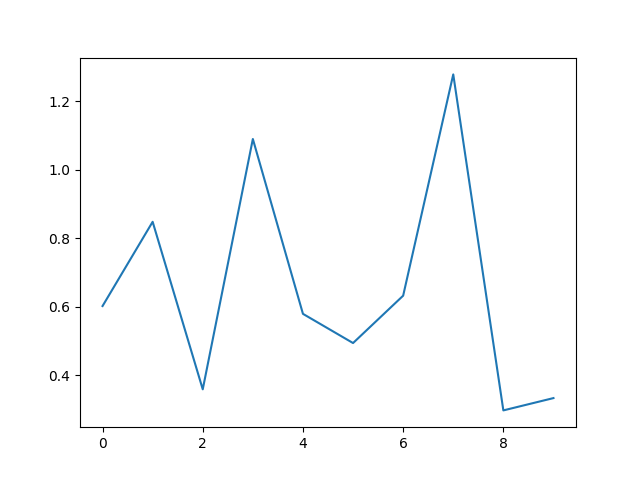

In [ ]:
plt.figure()
plt.plot(lrn.pred.cpu()[0,:,0]-lrn.pred.cpu()[0,:,1])

In [ ]:
mean_vaf(lrn.y[:,:3,1],lrn.pred[:,:3,1])

tensor(65.5437, device='cuda:0')

## Test

<IPython.core.display.Javascript object>


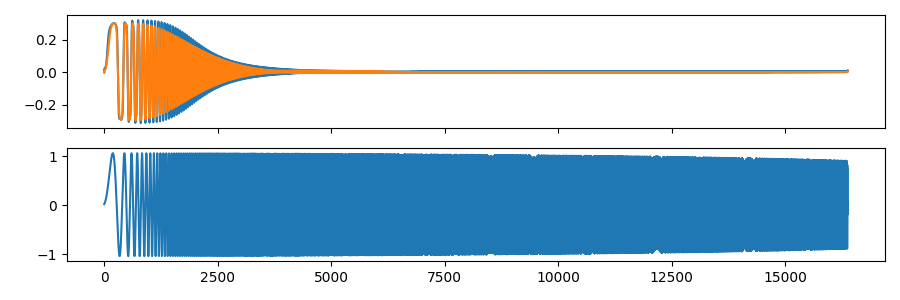

In [ ]:
lrn.show_results(dl=db_tst.train_dl)

In [ ]:
lrn.validate(dl=db_tst.train_dl)

(#2) [0.0001518213248346001,0.01232157927006483]